# This notebook examines the topic stablities

Other examples in the literature:

1. https://dl.acm.org/doi/full/10.1145/3623269

2. https://www.sciencedirect.com/science/article/pii/S0957417420305339
3. https://www.sciencedirect.com/science/article/pii/S0957417417305948
4. https://link.springer.com/chapter/10.1007/978-3-319-45982-0_16
5. https://www.kdd.org/kdd2016/papers/files/rpp1190-zuoA.pdf
6. https://link.springer.com/chapter/10.1007/978-3-662-44848-9_32


In [ ]:
import re
from collections import defaultdict
import numpy as np
import Levenshtein
from scipy.optimize import linear_sum_assignment
import Levenshtein
import matplotlib.pyplot as plt


## Load the data

In [ ]:
file_path = r"C:\Downloads\topic_model_tf-idf_socres_20_deterministic.txt" 

# Open the file in read mode
with open(file_path, 'r') as file:
    # Read all contents of the file
    file_content = file.read()

# Print the content to check
topic_its = file_content.split('&ITERATION_SPLITTER&')[1:]
#display(topic_its)
nr_its = len(topic_its)
nr_topics = len(topic_its[0].split('&TOPIC_SPLITTER&'))-1
print(nr_its)
print(nr_topics)

20
30


## Functions

In [3]:
def char_diff_percentage(word1, word2):
    if word1 == '':
        if word2 !='':
            word1 = '§'*len(word2)
        else:
            return 0
    length = max(len(word1), len(word2))
    differences = sum(c1 != c2 for c1, c2 in zip(word1.ljust(length), word2.ljust(length)))
    return differences / length * 100


In [4]:
def extract_words(topic_str):
    # This function extracts words from a topic string like 'direction (0.1494), near (0.1224), ...'
    words_with_weights = topic_str.split(',')
    words = [re.sub(r'\d+', '', w.split('(')[0].strip().replace('\n', '')) for w in words_with_weights]
    words = [item for item in words if item]  # Keeps only non-empty strings
    return words

In [5]:
def char_diff_percentage_lev(word1, word2):
    if word1 == '':
        if word2 !='':
            word1 = '§'*len(word2)
        else:
            return 0

    levenshtein_distance = Levenshtein.distance(word1, word2)
    max_length = max(len(word1), len(word2))
    
    return levenshtein_distance / max_length * 100

#qgram distance
def char_diff_percentage(word1, word2):
    if word1 == '':
        if word2 !='':
            word1 = '§'*len(word2)
        else:
            return 0
    length = max(len(word1), len(word2))
    differences = sum(c1 != c2 for c1, c2 in zip(word1.ljust(length), word2.ljust(length)))
    return differences / length * 100


In [6]:
def optimal_word_matching(words1, words2):
    # Create the distance matrix
    num_words1 = len(words1)
    num_words2 = len(words2)
    distance_matrix = np.zeros((num_words1, num_words2))

    for i, word1 in enumerate(words1):
        for j, word2 in enumerate(words2):
            distance_matrix[i, j] = char_diff_percentage_lev(word1, word2)

    # Use the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    
    # Calculate the differences based on the optimal matching, skipping pairs of empty strings
    differences = [
        distance_matrix[i, j] 
        for i, j in zip(row_ind, col_ind) 
        if not (words1[i] == words2[j] == '')
    ]
    
    # Calculate the mean difference
    mean_diff = np.mean(differences) if differences else 0
    return mean_diff, list(zip([words1[i] for i in row_ind], [words2[j] for j in col_ind]))



In [7]:
def generate_key(iter1, topic1, iter2, topic2):
    # Generate a consistent key where the smaller pair (when sorted as a string) is first
    pair1 = f"t{topic1}it{iter1}"
    pair2 = f"t{topic2}it{iter2}"
    return f"{pair1}_vs_{pair2}" #if pair1 < pair2 else f"{pair2}_vs_{pair1}" # this makes sure that each pair is always in the same order!


In [8]:
def compare_topics_across_iterations(topic_iterations):
    results = {}
    
    # Iterate through each topic in each iteration
    for iteration_idx, topic_iteration in enumerate(topic_iterations):
        topics_in_iteration = topic_iteration.split('&TOPIC_SPLITTER& Topic')  # Splitting topics based on the format
        topics_in_iteration =[item for item in topics_in_iteration if item != ' ']
        for topic_str1 in topics_in_iteration:
            topic_num1 = int(topic_str1.split('\n')[0]) #re.match(r'\d+', topic_str1).group()

            words1 = extract_words(topic_str1)
            # Compare with topics in all other iterations
            for other_iteration_idx, other_topic_iteration in enumerate(topic_iterations):
                if other_iteration_idx == iteration_idx:
                    continue  # Skip comparing with the same iteration
                
                other_topics_in_iteration = other_topic_iteration.split('&TOPIC_SPLITTER& Topic')
                other_topics_in_iteration =[item for item in other_topics_in_iteration if item != ' ']
                
                for topic_str2 in other_topics_in_iteration:
                    topic_num2 = int(topic_str2.split('\n')[0])#re.match(r'\d+', topic_str2).group()
                    words2 = extract_words(topic_str2)
                    
                    # Create a unique, order-agnostic key
                    key = generate_key(iteration_idx, topic_num1, other_iteration_idx, topic_num2)
                    
                    # Check if the comparison has already been done
                    if key in results:
                        continue

                    # Calculate mean difference for this pair of topics
                    # Compare each word in words1 with words2 by matching best matches
                    mean_diff = optimal_word_matching(words1, words2)
                    
                    # Store the result in the dictionary
                    results[key] = mean_diff 
    
    return results

In [9]:
def evaluate_key_occurrences(data, threshold, it, num_topics , num_its):
    # Dictionary to store counts of occurrences below the threshold for each key
    key_counts = {f't{topic}it{it}': (0, '') for topic in range(num_topics)}

    # Iterate through the data to evaluate occurrences
    for topic in range(num_topics):
        for it_to_compare in range(num_its):
            if it_to_compare != it:
                for topics_to_compare in range(num_topics):
                    key_look_for = f't{topic}it{it}_vs_t{topics_to_compare}it{it_to_compare}'
                    (val, words) = data[key_look_for]
                    if val <= threshold:
                        val, _ = key_counts[f't{topic}it{it}']
                        val +=1
                        key_counts[f't{topic}it{it}'] = (val, [pair[0] for pair in words])
                    else:
                        val, _ = key_counts[f't{topic}it{it}']
                        key_counts[f't{topic}it{it}'] = (val, [pair[0] for pair in words])
                         

    return key_counts

In [10]:
def find_max_threshold(results, nr_its, it, nr_topics, low, high):
    """
    Find the maximum threshold for which no value in key_counts exceeds nr_its.
    
    Parameters:
    - results: Data needed for evaluate_key_occurrences.
    - nr_its: The maximum allowed value in key_counts.
    - low: The minimum threshold value to consider.
    - high: The maximum threshold value to consider.
    
    Returns:
    - The largest valid threshold.
    """
    best_threshold = low  # Start with the lowest possible threshold
    
    while low <= high:
        mid = (low + high) // 2
        key_counts = evaluate_key_occurrences(results, mid, it=it, num_topics=nr_topics, num_its=nr_its)
        
        # Check if any value in key_counts exceeds nr_its
        if all(count < nr_its for count, _ in key_counts.values()):
            best_threshold = mid  # This threshold is valid, try for a higher value
            low = mid + 1
        else:
            high = mid - 1  # This threshold is too high, try a lower value
    
    return best_threshold


In [39]:
def plot_topic_stability(data, highlight_topics=None, nr_its=20, topic_diff_thresohold=0):
    # Sort data and prepare for plotting
    data = dict(sorted(data.items(), key=lambda item: item[1][0], reverse=False))

    # Prepare the data for plotting
    x_labels = []
    values = []
    highlight_colors = []

    # Convert highlight_topics to a set for faster lookup
    highlight_set = highlight_topics

    for idx, (key, (value, labels)) in enumerate(data.items()):
        label = str(labels).replace('[','').replace(']','')
        x_labels.append(label)
        values.append(int((value+1)/nr_its *100)) # here +1 since it always appears in the base iteration from which it is compared to all the others!
        # Highlight specific bars based on provided labels
        if label in highlight_set:
            highlight_colors.append('lightcoral')  # Highlight color
        else:
            highlight_colors.append('skyblue')  # Default color

    # Create the horizontal bar chart with adjusted figure size and bar height
    plt.figure(figsize=(16, 8))  # Increased figure size for a larger plot
    bars = plt.barh(x_labels, values, color=highlight_colors, height=0.6)  # Apply colors

    # Determine the x-axis limit
    max_value = max(values)
    plt.xlim(0, max_value*1.1)  # Set x-axis limit to be 3 units larger than the maximum value

    # Add labels and title with increased font size
    plt.xlabel(f'How often did this topic occur in \n other iterations with a word dif \n -ference of at most {topic_diff_thresohold}%', fontsize=14)
    plt.ylabel('Topics', fontsize=14)
    plt.title(f'Topic Stability over {nr_its} Topic Modelling Iterations', fontsize=20)

    # Increase size of the tick labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add value labels in the middle of each bar
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                 f'{bar.get_width()}', va='center', ha='left', fontsize=12)

    # Display the plot
    plt.tight_layout()  # Adjust layout to ensure labels fit well
    plt.show()

## Calculate the topic similarities

In [12]:
#
#
# Compute similarities between best matching words between topics across iterations
#
#
results = compare_topics_across_iterations(topic_its)

In [13]:
sorted_data = dict(sorted(results.items(), key=lambda item: item[1][0], reverse=False))
sorted_data

{'t0it0_vs_t5it1': (0.0,
  [('vaccinated', 'vaccinated'),
   ('vaccination', 'vaccination'),
   ('covid', 'covid'),
   ('corona', 'corona'),
   ('infections', 'infections'),
   ('pandemic', 'pandemic'),
   ('via', 'via'),
   ('people', 'people'),
   ('incidence', 'incidence'),
   ('cases', 'cases')]),
 't0it0_vs_t11it2': (0.0,
  [('vaccinated', 'vaccinated'),
   ('vaccination', 'vaccination'),
   ('covid', 'covid'),
   ('corona', 'corona'),
   ('infections', 'infections'),
   ('pandemic', 'pandemic'),
   ('via', 'via'),
   ('people', 'people'),
   ('incidence', 'incidence'),
   ('cases', 'cases')]),
 't0it0_vs_t13it3': (0.0,
  [('vaccinated', 'vaccinated'),
   ('vaccination', 'vaccination'),
   ('covid', 'covid'),
   ('corona', 'corona'),
   ('infections', 'infections'),
   ('pandemic', 'pandemic'),
   ('via', 'via'),
   ('people', 'people'),
   ('incidence', 'incidence'),
   ('cases', 'cases')]),
 't0it0_vs_t14it4': (0.0,
  [('vaccinated', 'vaccinated'),
   ('vaccination', 'vaccinatio

## Find iteration and corresponding topics with the highes topic stabilitiy

In [18]:
#
#
# Identify threshold after which one topic in iteration x is matched to several topics in iteration y
#
# 


initial_low = 0  # Starting threshold (you might need to adjust this)
initial_high = 100  # An arbitrary large value for the maximum threshold

# check over all iterations
max_thresholds_over_iterations = []
for it in range(nr_its):
    max_threshold = find_max_threshold(results,  nr_its, it, nr_topics, initial_low, initial_high)
    max_thresholds_over_iterations.append(max_threshold)
threshold = min(max_thresholds_over_iterations)
print(f"The largest valid threshold for which one topic only matches with one other topic per iteration, over all iteration is: {threshold} %")


The largest valid threshold for which one topic only matches with one other topic per iteration, over all iteration is: 17


In [19]:
#
#
# Idntify the iteration with the most stable topics
#
#

# check over all iterations
key_counts_dict = {}
for i in range(nr_its):
    key_counts = evaluate_key_occurrences(results, threshold, it=i, num_topics = nr_topics, num_its= nr_its)
    values = []
    for key in key_counts.keys():
        values.append(key_counts[key][0])
    key_counts_dict[i] = np.mean(values)

key_with_max_value = max(key_counts_dict, key=key_counts_dict.get)
print(f'The most stable topics were reached in iteration {key_with_max_value}')

The most stable topics were reached in iteration 2


## Plot and understand the most stable topics and their stability distribution

In [24]:
it = key_with_max_value
threshold = threshold
key_counts = evaluate_key_occurrences(results, threshold, it=it, num_topics = nr_topics, num_its= nr_its)
#plot_key_occurrences(key_counts)
counter=1
for el in key_counts.values():
    words = str(el[1]).replace('[','').replace(']','')
    print(el)
    counter+=1

(17, ['climate', 'change', 'crisis', 'climatecrisis', 'catastrophe', 'protection', 'energy', 'extreme', 'heat', 'climateactionnow'])
(16, ['limburg', 'water', 'maas', 'high', 'flooding', 'venlo', 'valkenburg', 'maastricht', 'watersnood', 'south'])
(19, ['cologne', 'intensity', 'precipitation', 'area', 'koelle'])
(11, ['towards', 'direction', 'closed', 'near', 'blocked', 'bastogne', 'li', 'flooding', 'charleroi', 'travel'])
(8, ['people', 'affected', 'flood', 'disaster', 'many', 'victims', 'floods', 'solidarity', 'help', 'thanks'])
(2, ['country', 'poland', 'italy', 'uk', 'people', 'hunger', 'strike', 'schoenstatt', 'schoenstattorg', 'srebrenica'])
(19, ['pastoral', 'care', 'emergency', 'koblenz', 'mayen', 'mission', 'landkreismayenkoblenz', 'deployment', 'districtmayenkoblenz', 'operation'])
(19, ['mh', 'mystery', 'solved', 'youtube', 'check', 'video', 'judge', 'answers', 'research', 'questions'])
(14, ['ahrweiler', 'flood', 'help', 'germany', 'donations', 'bonn', 'district', 'ahr', 'f

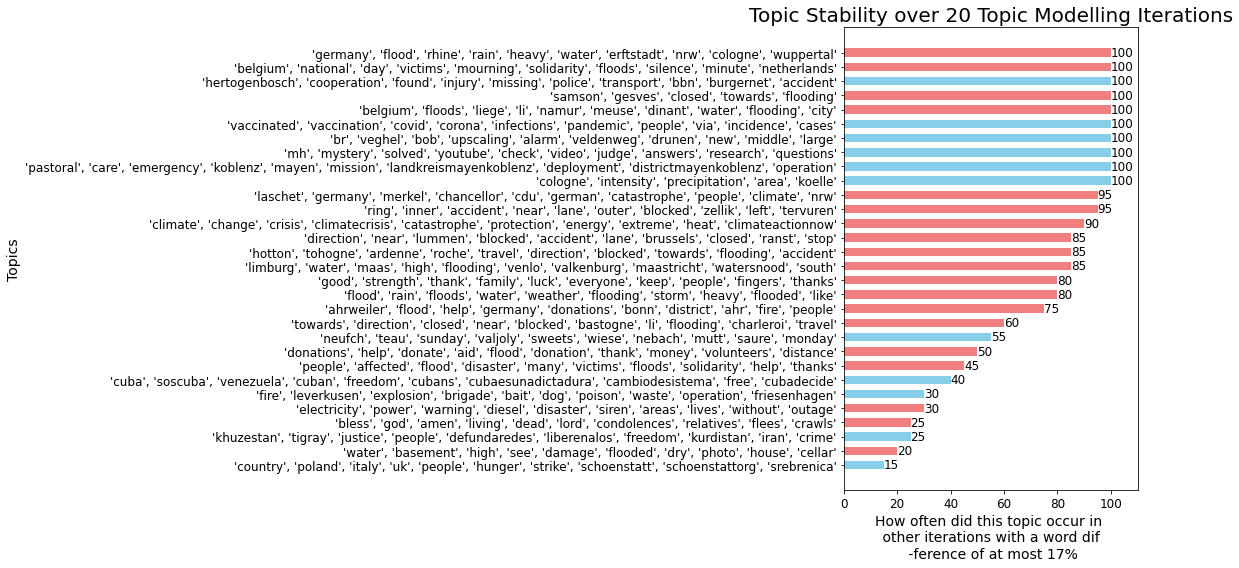

In [41]:
#C:\Users\b1066706\Downloads\topic_model_tf-idf_socres_20.txt
# it:13
# topics=30
# random seeds: [365, 782, 60, 284, 896, 479, 401, 894, 142, 412, 153, 623, 625, 230, 846, 351, 652, 494, 586, 465]
highlight_topics = ["'flood', 'rain', 'floods', 'water', 'weather', 'flooding', 'storm', 'heavy', 'flooded', 'like'",
 "'direction', 'near', 'lummen', 'blocked', 'accident', 'lane', 'brussels', 'closed', 'ranst', 'stop'",
 "'ring', 'inner', 'accident', 'near', 'lane', 'outer', 'blocked', 'zellik', 'left', 'tervuren'",
 "'hotton', 'tohogne', 'ardenne', 'roche', 'travel', 'direction', 'blocked', 'towards', 'flooding', 'accident'",
 "'samson', 'gesves', 'closed', 'towards', 'flooding'",
 "'towards', 'direction', 'closed', 'near', 'blocked', 'bastogne', 'li', 'flooding', 'charleroi', 'travel'",
 "'limburg', 'water', 'maas', 'high', 'flooding', 'venlo', 'valkenburg', 'maastricht', 'watersnood', 'south'",
 "'belgium', 'floods', 'liege', 'li', 'namur', 'meuse', 'dinant', 'water', 'flooding', 'city'",
 "'germany', 'flood', 'rhine', 'rain', 'heavy', 'water', 'erftstadt', 'nrw', 'cologne', 'wuppertal'",
 "'ahrweiler', 'flood', 'help', 'germany', 'donations', 'bonn', 'district', 'ahr', 'fire', 'people'",
 "'water', 'basement', 'high', 'see', 'damage', 'flooded', 'dry', 'photo', 'house', 'cellar'",
 "'electricity', 'power', 'warning', 'diesel', 'disaster', 'siren', 'areas', 'lives', 'without', 'outage'",
 "'people', 'affected', 'flood', 'disaster', 'many', 'victims', 'floods', 'solidarity', 'help', 'thanks'",
 "'donations', 'help', 'donate', 'aid', 'flood', 'donation', 'thank', 'money', 'volunteers', 'distance'",
 "'bless', 'god', 'amen', 'living', 'dead', 'lord', 'condolences', 'relatives', 'flees', 'crawls'",
 "'good', 'strength', 'thank', 'family', 'luck', 'everyone', 'keep', 'people', 'fingers', 'thanks'",
 "'belgium', 'national', 'day', 'victims', 'mourning', 'solidarity', 'floods', 'silence', 'minute', 'netherlands'",
 "'laschet', 'germany', 'merkel', 'chancellor', 'cdu', 'german', 'catastrophe', 'people', 'climate', 'nrw'",
 "'climate', 'change', 'crisis', 'climatecrisis', 'catastrophe', 'protection', 'energy', 'extreme', 'heat', 'climateactionnow'"
]

plot_topic_stability(key_counts, highlight_topics, nr_its=nr_its, topic_diff_thresohold=threshold)


## Side notes

Here we assessed the topic stability for different random seeds, while this might also be different for different numbers of topics and other hyperparameters. This could be assessed in future reasearch.